## Setup

In [4]:
import os
import sys

IN_COLAB = "google.colab" in sys.modules

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

os.environ["OPENAI_API_KEY"] = "YOUR-KEY-HERE!"
os.environ["HUGGINGFACE_KEY"] = "YOUR-KEY-HERE!"

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
root = "/content"

if IN_COLAB:
    %pip install "torch>=2.1.0" einops datasets jaxtyping "sae_lens>=3.23.1" openai tabulate "nbformat>=4.2.0" umap-learn hdbscan eindex-callum git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python git+https://github.com/callummcdougall/sae_vis.git@callum/v3 "transformer-lens>=2.7.0"

if not os.path.exists(f"{root}/{chapter}"):
    !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
    !unzip {root}/main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
    !mv {root}/{repo}-main/{chapter} {root}/{chapter}
    !rm {root}/main.zip
    !rmdir {root}/{repo}-main
    sys.path.append(f"{root}/{chapter}/exercises")

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-je95cu8q
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-je95cu8q
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/callummcdougall/sae_vis.git (to revision callum/v3) to /tmp/pip-req-build-xo5ollo3
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/sae_vis.git /tmp/pip-req-build-xo5ollo3
  Running command git checkout -b callum/v3 --track origin/callum/v3
  Switched to a new branch 'callum/v3'
  Branch 'callum/v3' set up to track remote branch 'callum/v3' from 'origin'.
  Resolved https://github.com/callummcdougall/sae_vis.git to commit 8fab7643c24c8d285b64b1b0c291d1

--2024-12-06 14:48:53--  https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main [following]
--2024-12-06 14:48:53--  https://codeload.github.com/callummcdougall/ARENA_3.0/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [   <=>              ]  87.07M  8.97MB/s    in 10s     

2024-12-06 14:49:04 (8.51 MB/s) - ‘main.zip’ saved [91304703]

Archive:  /content/main.zip
0353a7c1153973204a11ed7e3b35026944604dd8
   creating: ARENA_3.0-main/chapter1_transformer_interp/exer

In [5]:
import gc
import itertools
import math
import os
import random
import sys
from collections import Counter
from copy import deepcopy
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Any, Callable, Literal, TypeAlias

import einops
import numpy as np
import pandas as pd
import plotly.express as px
import requests
import torch as t
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from IPython.display import HTML, IFrame, clear_output, display
from jaxtyping import Float, Int
from openai import OpenAI
from rich import print as rprint
from rich.table import Table
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_vis import SaeVisConfig, SaeVisData, SaeVisLayoutConfig
from tabulate import tabulate
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part32_interp_with_saes").resolve()
if str(exercises_dir) not in sys.path:
    sys.path.append(str(exercises_dir))

import part31_superposition_and_saes.tests as part31_tests
import part31_superposition_and_saes.utils as part31_utils
import part32_interp_with_saes.tests as part32_tests
import part32_interp_with_saes.utils as part32_utils
from plotly_utils import imshow, line

MAIN = __name__ == "__main__"

In [6]:
# For displaying sae-vis inline
import http.server
import socketserver
import threading
import webbrowser

from google.colab import output

PORT = 8000


def display_vis_inline(filename: Path, height: int = 850):
    """
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    """
    global PORT

    def serve(directory):
        os.chdir(directory)
        handler = http.server.SimpleHTTPRequestHandler
        with socketserver.TCPServer(("", PORT), handler) as httpd:
            print(f"Serving files from {directory} on port {PORT}")
            httpd.serve_forever()

    thread = threading.Thread(target=serve, args=("/content",))
    thread.start()

    filename = str(filename).split("/content")[-1]

    output.serve_kernel_port_as_iframe(PORT, path=filename, height=height, cache_in_notebook=True)

    PORT += 1

## Main Idea
- Build a (multiple) Toy Model(s) such as the one in https://colab.research.google.com/drive/1ePkM8oBHIEZ2kcqAiA3waeAmz8RSdHmq#scrollTo=0_wxCyBwZ38Q in which to force superposition
- Apply Iterative Magnitude pruning to such model and see how the features representation changes.

The model is as follows:

* We take a 5-dimensional input $x$
* We map it down into 2D space
* We map it back up into 5D space (using the transpose of the first matrix)
* We add a bias and ReLU

$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b)
\end{aligned}
$$

### What's the motivation for this setup?

The input $x$ represents our five features (they're uniformly sampled between 0 and 1).

Each feature can have **importance** and **sparsity**. Recall our earlier definitions:

* **Importance** = how useful is this feature for achieving lower loss?
* **Sparsity** = how frequently is it in the input data?

This is realised in our toy model as follows:

* **Importance** = the coefficient on the weighted mean squared error between the input and output, which we use for training the model
    * In other words, our loss function is $L = \sum_x \sum_i I_i (x_i - x_i^\prime)^2$, where $I_i$ is the importance of feature $i$.
* **Sparsity** = the probability of the corresponding element in $x$ being zero
    * In other words, this affects the way our training data is generated (see the method `generate_batch` in the `Module` class below)
    * We often refer to **feature probability** (1 minus sparsity) rather than sparsity

The justification for using $W^T W$ is as follows: we can think of $W$ (which is a matrix of shape `(2, 5)`) as a grid of "overlap values" between the features and bottleneck dimensions. The values of the 5x5 matrix $W^T W$ are the dot products between the 2D representations of each pair of features. To make this intuition clearer, imagine each of the columns of $W$ were unit vectors, then $W^T W$ would be a matrix of cosine similarities between the features (with diagonal elements equal to 1, because the similarity of a feature with itself is 1). To see this for yourself:

In [8]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600)

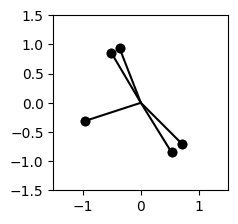

In [9]:
part31_utils.plot_features_in_2d(
    W_normed.unsqueeze(0),  # shape [instances=1 d_hidden=2 features=5]
)

In [12]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

@dataclass
class ToyModelConfig:
    n_inst: int # Number of toy models trained simultaneously
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "jump"] = "unif"

class ToyModel(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    def __init__(
        self,
        cfg: ToyModelConfig,
        feature_probability: float | Tensor = 0.01,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(ToyModel, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_inst, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... inst feats"],
    ) -> Float[Tensor, "... inst feats"]:
        """
        Performs a single forward pass. For a single instance, this is given by:
            x -> ReLU(W.T @ W @ x + b_final)
        """
        h = einops.einsum(features, self.W, "... inst feats, inst hidden feats -> ... inst hidden")
        out = einops.einsum(h, self.W, "... inst hidden, inst hidden feats -> ... inst feats")
        return F.relu(out + self.b_final)


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)

    def generate_batch(self: ToyModel, batch_size: int) -> Float[Tensor, "batch inst feats"]:
        """
        Generates a batch of data.
        """
        batch_shape = (batch_size, self.cfg.n_inst, self.cfg.n_features)
        feat_mag = t.rand(batch_shape, device=self.W.device)
        feat_seeds = t.rand(batch_shape, device=self.W.device)
        return t.where(feat_seeds <= self.feature_probability, feat_mag, 0.0)

    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        """
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `self.importance` will always have shape (n_inst, n_features).
        """
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, "batch inst feats -> inst", "mean").sum()
        return loss



  0%|          | 0/10000 [00:00<?, ?it/s]

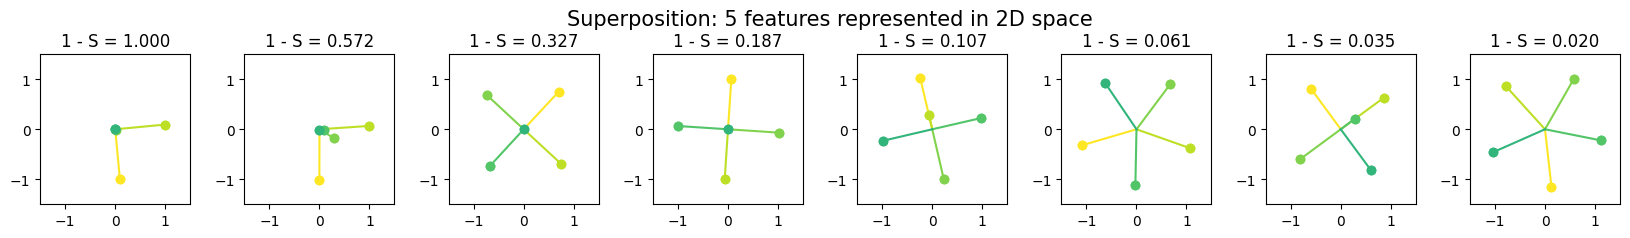

In [13]:
cfg = ToyModelConfig(n_inst=8, n_features=5, d_hidden=2)

# importance varies within features for each instance
importance = 0.9 ** t.arange(cfg.n_features)

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = 50 ** -t.linspace(0, 1, cfg.n_inst)

line(
    importance,
    width=600,
    height=400,
    title="Importance of each feature (same over all instances)",
    labels={"y": "Feature importance", "x": "Feature"},
)
line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

part31_utils.plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

Remember that for all these diagrams, **the darker colors have lower importance** and **the lighter colors have higher importance**. Also, the sparsity of all features is increasing as we move from left to right (at the far left there is no sparsity, at the far right feature probability is 5% for all features, i.e. sparsity of 95%).

### Interpretation

When there is no sparsity, the model can never represent more than 2 features faithfully, so it makes sense for it to only represent the two most important features. It stores them orthogonally in 2D space, and sets the other 3 features to zero. This way, it can reconstruct these two features perfectly, and ignores all the rest.

When there is high sparsity, we get a pentagon structure. Most of the time at most one of these five features will be active, which helps avoid interference between features. When we try to recover our initial features by projecting our point in 2D space onto these five directions, most of the time when feature i is present, we can be confident that our projection onto the i-th feature direction only captures this feature, rather than being affected by the presence of other features. We omit the mathematical details here.

The key idea here is that two forces are competing in our model: **feature benefit** (representing more thing is good!), and **interference** (representing things non-orthogonally is bad). The higher the sparsity, the more we can reduce the negative impact of interference, and so the trade-off skews towards "represent more features, non-orthogonally".

Let's generate a batch of examples:

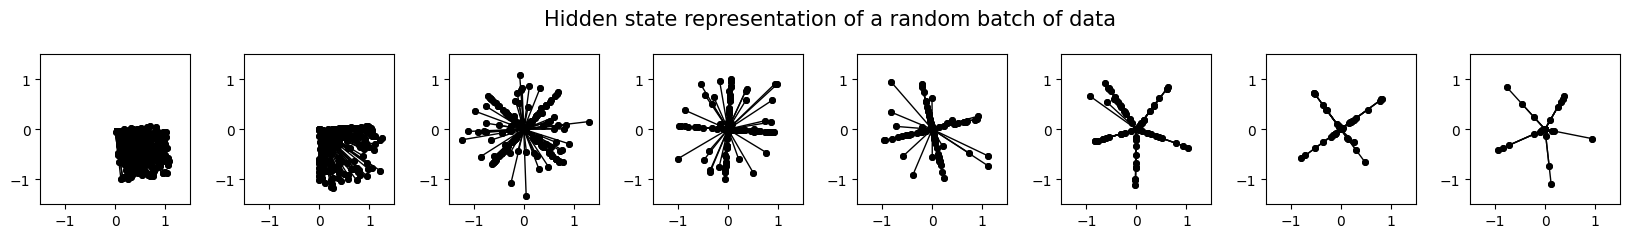

In [14]:
with t.inference_mode():
    batch = model.generate_batch(200)
    hidden = einops.einsum(
        batch,
        model.W,
        "batch_size instances features, instances hidden features -> instances hidden batch_size",
    )

part31_utils.plot_features_in_2d(hidden, title="Hidden state representation of a random batch of data")

Most interestingly, you should see that in the plots with high sparsity (to the right), we very rarely have interference between the five features, because most often ≤1 of those features is present, and the model can recover it by projecting along the corresponding feature dimension without losing any information.

## Visualizing features across varying sparsity

In [ ]:
cfg = ToyModelConfig(n_inst=10, n_features=100, d_hidden=20)

importance = 100 ** -t.linspace(0, 1, cfg.n_features)
feature_probability = 20 ** -t.linspace(0, 1, cfg.n_inst)

line(
    importance,
    width=600,
    height=400,
    title="Importance of each feature (same over all instances)",
    labels={"y": "Feature importance", "x": "Feature"},
)
line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Because we can't plot features in 2D anymore, we're going to use a different kind of visualisation:

* The **bottom row plots** shows a bar graph of all the features and their corresponding embedding norms $||W_i||$.
    * As we increase sparsity, the model is able to represent more features (i.e. we have more features with embedding norms close to 1).
    * We also color the bars according to whether they're orthogonal to other features (purple) or not (yellow). So we can see that for low sparsity most features are represented orthogonally (like our left-most plots above) but as we increase sparsity we transition to all features being represented non-orthogonally (like our right-most pentagon plots above).
* The **top row plots** show us the dot products between all pairs of feature vectors (kinda like the heatmaps we plotted at the start of this section).
    * This is another way of visualising the increasing interference between features as we increase sparsity.
    * Note that all these right hand plots represent **matrices with rank at most `d_hidden=20`**. The first few are approximately submatrices of the identity (because we perfectly reconstruct 20 features and delete the rest), but the later plots start to display inference as we plot more than 20 values (the diagonals of these matrices have more than 20 non-zero elements).

See the section [Basic Results](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-basic-results) for more of an explanation of this graph and what you should interpret from it.

In [ ]:
part31_utils.plot_features_in_Nd(
    model.W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 80, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probability],
)